## MultiModel Approach for Detecting Hate Speech in Memes

### Authors

- Sai Shishir Ailneni
- Priyaanka Reddy Boothkuri
- Manogna Tummanepally

## Introduction

This notebook demonstrates a method for detecting hate speech in memes using a combined approach of text and image analysis. We utilize TensorFlow and Keras to build a multimodal model that processes both the textual and visual components of memes. The goal is to create a robust classifier that can accurately identify hate speech content in a diverse set of digital media.

## Import Required Libraries¶
Here, we import all necessary libraries that will be used throughout the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_auc_score,roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Embedding, GlobalAveragePooling1D, Conv2D, MaxPooling2D, Flatten

np.random.seed(9012023)

## Data Loading and Preprocessing

The dataset consists of memes which are represented through their text content and images. Here, we load the dataset, create file paths for the images, and split the data into training and test sets.


In [2]:
data = pd.read_json('./data/train.jsonl', lines=True)

In [3]:
data['img_path'] = './data/' + data['img']

In [4]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

## Text and Image Preprocessing

To ensure our model can interpret the data, we need to preprocess both the text and images. Text data will undergo tokenization and vectorization, while images will be resized and normalized.

In [5]:
# Text preprocessing
vectorize_layer = TextVectorization(max_tokens=10000, output_mode='int')
vectorize_layer.adapt(data['text'])

In [6]:
def preprocess_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

In [7]:
# Image preprocessing
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Assuming images are in JPEG format
    image = tf.image.resize(image, [64, 64])  # Resize images
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

In [8]:
def prepare_dataset(df):
    text_data = preprocess_text(df['text'].values)
    image_data = np.stack(df['img_path'].apply(load_and_preprocess_image))
    labels = df['label'].values
    return (text_data, image_data), labels

In [9]:
(x_train_text, x_train_images), y_train = prepare_dataset(train_df)
(x_test_text, x_test_images), y_test = prepare_dataset(test_df)

## Model Architecture

The model architecture consists of two branches: one for text using embeddings and global pooling, and one for images using convolutional layers. These branches are then merged to form a combined feature set for classification.

In [10]:
# Define the text model
text_input = Input(shape=(None,), dtype=tf.int64, name='text_input')
text_embedding = Embedding(input_dim=10000, output_dim=64)(text_input)
text_output = GlobalAveragePooling1D()(text_embedding)

In [11]:
image_input = Input(shape=(64, 64, 3), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
image_output = Flatten()(x)

In [12]:
# Combine text and image features
combined_features = Concatenate()([text_output, image_output])
x = Dense(128, activation='relu')(combined_features)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
final_output = Dense(1, activation='sigmoid')(x)

In [13]:
model = Model(inputs=[text_input, image_input], outputs=final_output)


In [14]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 64)  │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ embedding[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 9280)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,187,968 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,892,609 (7.22 MB)

 Trainable params: 1,892,609 (7.22 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

We now train the model on the prepared datasets and plot the training and validation accuracy and losses to evaluate the model's performance over epochs.

In [16]:
history = model.fit([x_train_text, x_train_images], y_train, validation_data=([x_test_text, x_test_images], y_test), epochs=10, batch_size=32)

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 144ms/step - accuracy: 0.6282 - loss: 0.6648 - val_accuracy: 0.6324 - val_loss: 0.6538
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.6450 - loss: 0.6517 - val_accuracy: 0.6324 - val_loss: 0.6545
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.6503 - loss: 0.6427 - val_accuracy: 0.6324 - val_loss: 0.6399
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 140ms/step - accuracy: 0.6429 - loss: 0.6400 - val_accuracy: 0.6771 - val_loss: 0.6211
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.6987 - loss: 0.5878 - val_accuracy: 0.6894 - val_loss: 0.6138
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 39s 182ms/step - accuracy: 0.7420 - loss: 0.5298 - val_accuracy: 0.6829 - val_loss: 0.6197
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.7583 - loss: 0.5121 - val_accuracy: 0.6847 - val_loss: 0.6283
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 37s 154ms/step - accuracy: 0.7900 - loss: 0

## Visualization of Training Process

We plot the training and validation accuracy and loss to evaluate the model's performance throughout the training epochs.

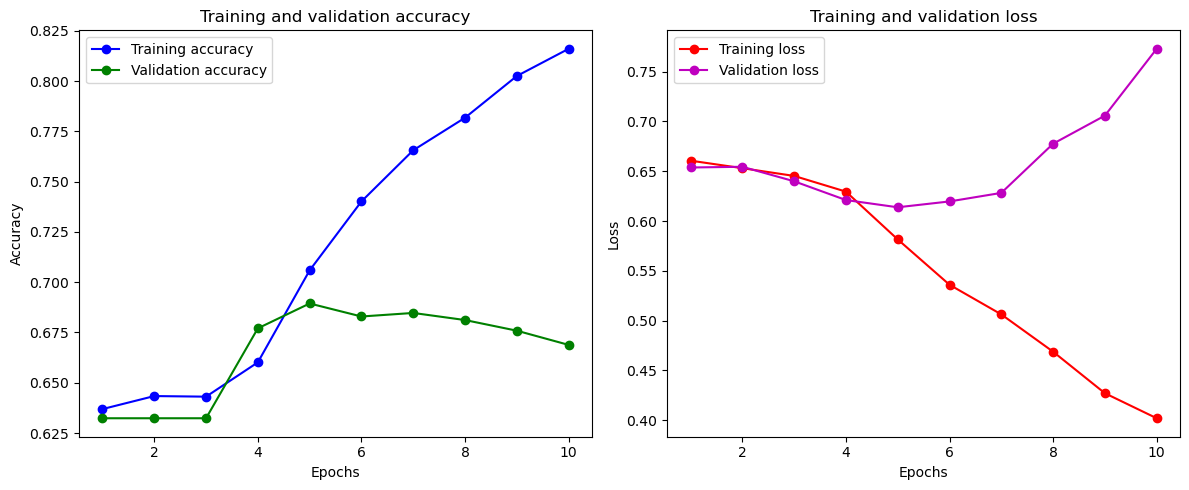

In [17]:
# Extracting the data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro-', label='Training loss')
plt.plot(epochs, val_loss, 'mo-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation and Analysis

After training, we evaluate the model's performance on the test set and display key metrics such as accuracy, precision, recall, and F1-score. Additionally, we plot the Receiver Operating Characteristic (ROC) curve to assess the model's discriminative capability.

In [18]:
# Predicting test data
y_pred_proba = model.predict([x_test_text, x_test_images])
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Area Under Curve:", auc)

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
Confusion Matrix:
 [[866 209]
 [354 271]]
Accuracy: 0.6688235294117647
Precision: 0.5645833333333333
Recall: 0.4336
F1 Score: 0.49049773755656106
Area Under Curve: 0.664705488372093


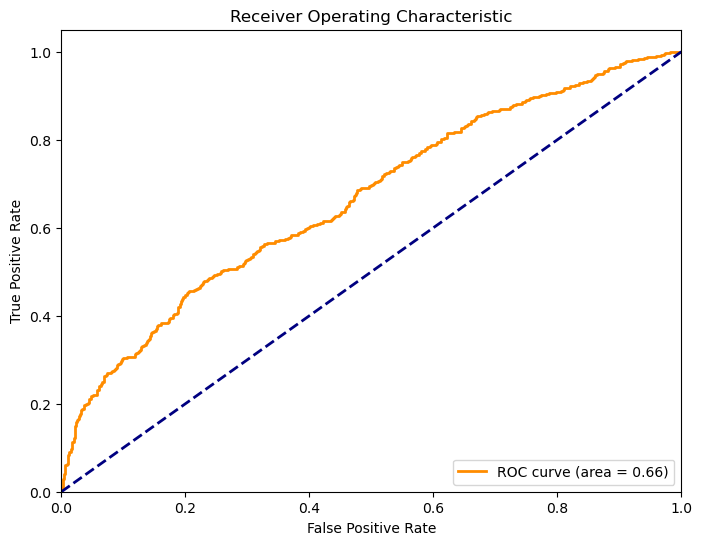

In [19]:
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Call the function to plot the ROC curve
plot_roc_curve(y_test, y_pred_proba)

## Conclusion and Analysis

### Model Performance Overview

Our multimodal model that combines text and image analysis to detect hate speech in memes achieved a test accuracy of 66.88%. Here are the key performance metrics observed:

- **Accuracy:** 66.88%
- **Precision:** 56.46%
- **Recall:** 43.36%
- **F1 Score:** 49.05%
- **Area Under Curve (AUC):** 66.47%

These results reflect a moderate level of effectiveness in detecting hate speech, indicating that the model can differentiate between hate speech and non-hate speech to a certain extent but still struggles with a balanced detection capability across both classes.

### Insights into Training Dynamics and Model Limitations

- **Training and Validation Performance:** The training process exhibited an increase in accuracy over the epochs, peaking at 81.46% accuracy on the training set. However, validation accuracy showed a peak at 68.88% before declining, suggesting the model began to overfit to the training data.

- **Loss Trends:** Both training and validation loss decreased initially, with training loss continuing to trend downwards while validation loss increased after the sixth epoch. This divergence between training and validation loss is a classic indication of overfitting, where the model learns the training data too well, including its noise and anomalies, at the expense of its ability to generalize to unseen data.

### Model Limitations and Data Handling Issues

- **Complexity in Multimodal Integration:** While integrating text and image data is theoretically beneficial for a comprehensive understanding of memes, it introduces complexity in aligning and effectively merging these modalities. The model may struggle to balance the contributions from each modality, potentially leading to underutilization of informative features from either text or images.

- **Generalization Challenges:** The decline in validation accuracy and increase in validation loss suggest that the model's generalization to new examples is limited. This could be due to the model architecture being overly complex or not having enough regularization to prevent it from fitting too closely to the training data.

### Recommendations for Future Improvements

- **Improved Modality Fusion:** Explore different methods for combining features from text and images. Techniques such as attention mechanisms or more complex fusion layers could provide better ways to integrate and weigh information from both sources.

- **Regularization Techniques:** Implement additional regularization strategies like L1/L2 regularization, dropout in earlier layers, or even experimenting with simpler models if overfitting continues to be an issue.

- **Advanced Preprocessing:** For text, consider using more sophisticated vectorization techniques like embeddings from pre-trained models (e.g., BERT). For images, experiment with different image augmentation techniques to make the model more robust to variations in visual data.

- **Cross-Validation:** Utilize cross-validation during model training to better understand the model's performance and stability across different subsets of data, helping to ensure that the model is both robust and generalizable.

### Final Thoughts

Despite the challenges, the multimodal approach holds promise for enhancing the detection of hate speech by leveraging the complementary strengths of textual and visual analysis. Continued refinement and testing on diverse and larger datasets are essential for advancing the model's capability to detect complex and subtle forms of hate speech in digital media.